# **Coronavirus tweets classification**

This is a notebook which takes Corona Virus tweet Data and classifies into different categories.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


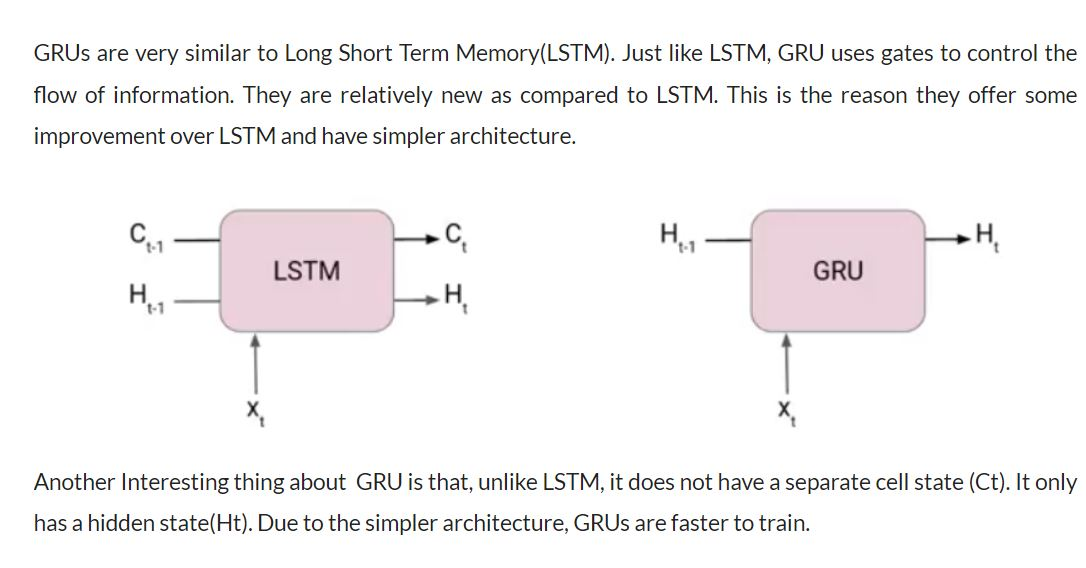

**1. Import libraries**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import layers

**2. Read data**

In [3]:
df_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Labs_MSc/Corona_NLP_train.csv",encoding='latin1')
df_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Labs_MSc/Corona_NLP_test.csv",encoding='latin1')

In [4]:
df_train.head(7) # check data (first 7 rows)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative
5,3804,48756,"ÃT: 36.319708,-82.363649",16-03-2020,As news of the regionÂs first confirmed COVID...,Positive
6,3805,48757,"35.926541,-78.753267",16-03-2020,Cashier at grocery store was sharing his insig...,Positive


In [5]:
df_test.head(7) # check data (first 7 rows)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral
5,6,44958,Los Angeles,03-03-2020,Do you remember the last time you paid $2.99 a...,Neutral
6,7,44959,NaN,03-03-2020,Voting in the age of #coronavirus = hand sanit...,Positive


In [6]:
df_train.shape # check data

(41157, 6)

In [7]:
df_test.shape # check data

(3798, 6)

**3. Visualize data**

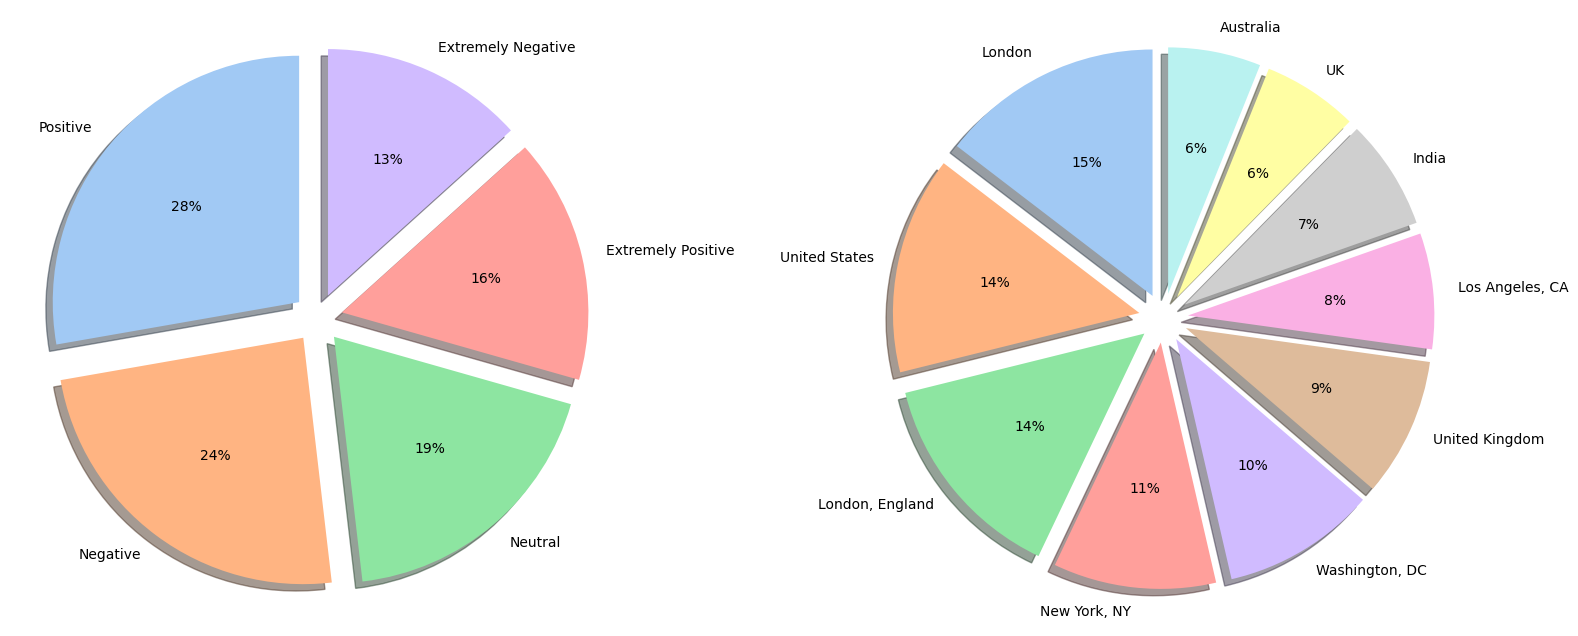

In [8]:
def plot_pie(df, column, axes, amount=-1):
    """ PIE PLOT """
    count_classes = df[column].value_counts()
    if (amount != -1):
        count_classes = count_classes[:amount]
    n_classes = len(count_classes)
    explode = (0.1,) * n_classes # explode for 0.1 each slice
    colors = sns.color_palette('pastel') # pastel colors
    axes.pie(count_classes,
             labels=count_classes.index,
             explode=explode,
             colors=colors,
             autopct='%.0f%%',
             shadow=True,
             startangle=90)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
plot_pie(df_train, "Sentiment", axes[0])
plot_pie(df_train, "Location", axes[1], 10) # only first 10 locations
plt.show()

**4. Prepare data**

Here we convert text labels to numeric labels
(e.g. "Sentiment" = {0,1,..4}).

In [9]:
y = df_train["Sentiment"].map({"Negative":0,
                               "Positive": 1,
                               "Neutral": 2,
                               "Extremely Positive": 3,
                               "Extremely Negative": 4
                               })

y_test = df_test["Sentiment"].map({"Negative":0,
                                   "Positive": 1,
                                   "Neutral": 2,
                                   "Extremely Positive": 3,
                                   "Extremely Negative": 4
                                                })

After that, we count **unique values to get the number of classes**.

In [10]:
# get the number of classes
n_classes = df_train["Sentiment"].nunique()
n_classes

5

**5. TextVectorization**

TextVectorization transforms a batch of strings into either a list of token indices or a dense representation.

In [11]:
# extract text data from dataframe
X = df_train['OriginalTweet'].to_numpy()
X_test = df_test['OriginalTweet'].to_numpy()

In [12]:
# TextVectorization transforms a batch of strings into either a list of token indices or a dense representation
text_vectorizer = TextVectorization(max_tokens=10000,
                                    standardize="lower_and_strip_punctuation",
                                    output_sequence_length=15)

In [13]:
# adapt dataset
text_vectorizer.adapt(X)

'''
The adapt() method · TextVectorization : holds a mapping between string tokens and integer indices
 StringLookup and IntegerLookup
'''

In [15]:
# example
text_vectorizer(["Natural Language Processing and deep learning"])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[1733, 5288, 3139,    4, 1661, 2049,    0,    0,    0,    0,    0,
           0,    0,    0,    0]])>

In [16]:
# the get_vocabulary() function provides
# the vocabulary to build a metadata file
# with one token per line
words = text_vectorizer.get_vocabulary()
# The vocabulary contains the padding
# token ('') and OOV token ('[UNK]')
#A Out-Of-Vocabulary (OOV) Word is a Linguistic Unit or a token that does not appear in training vocabulary or document.
#he unknown_token (UNK) is used when what remains of the token is not in the vocabulary, or if the token is too long.
# as well as the passed tokens
words[:10] # check data

['', '[UNK]', 'the', 'to', 'and', 'of', 'a', 'in', 'coronavirus', 'covid19']

**6. Embedding**

Embedding turns positive integers (indexes) into dense vectors of fixed size.

In [17]:
# turns positive integers (indexes)
# into dense vectors of fixed size
embedding = Embedding(input_dim=10000,
                      output_dim=128,
                      input_length=15,
                      name = 'embeding_1')
embedding

In [19]:
# example
#sample_embed = embedding(text_vectorizer(["Computer vision and deep learning"]))
sample_embed = embedding(text_vectorizer([" Natural Language Processing and deep learning"]))
sample_embed

<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.01267928, -0.03935485, -0.00318513, ..., -0.0382904 ,
          0.04839139, -0.00247995],
        [-0.02109435, -0.04505317,  0.00153842, ...,  0.04052356,
          0.03271404,  0.01895514],
        [ 0.01563008,  0.04929778, -0.04028026, ...,  0.04728198,
          0.01586599, -0.00299947],
        ...,
        [-0.00058539, -0.04481214, -0.04412799, ..., -0.03263   ,
          0.04034189, -0.03141911],
        [-0.00058539, -0.04481214, -0.04412799, ..., -0.03263   ,
          0.04034189, -0.03141911],
        [-0.00058539, -0.04481214, -0.04412799, ..., -0.03263   ,
          0.04034189, -0.03141911]]], dtype=float32)>

**7. Train our models**

Here we are going to train our models.

But, before training, we'll define some helpful functions.

In [20]:
def calculate_results(y_true, y_pred):
    # Calculate model accuracy
    model_accuracy = accuracy_score(y_true, y_pred) * 100
    # Calculate model precision,
    # recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true,
                                                                                 y_pred,
                                                                                 average="weighted")
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [21]:
def plot_NN_history(model_history, suptitle):
    # plot data
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,6))
    fig.suptitle(suptitle, fontsize=18)

    axes[0].plot(model_history.history['accuracy'],
                 label='train accuracy',
                 color='g',
                 axes=axes[0])
    axes[0].plot(model_history.history['val_accuracy'],
                 label='val accuracy',
                 color='r',
                 axes=axes[0])
    axes[0].set_title("Model Accuracy", fontsize=16)
    axes[0].legend(loc='upper left')

    axes[1].plot(model_history.history['loss'],
                 label='train loss',
                 color='g',
                 axes=axes[1])
    axes[1].plot(model_history.history['val_loss'],
                 label='val loss',
                 color='r',
                 axes=axes[1])
    axes[1].set_title("Model Loss", fontsize=16)
    axes[1].legend(loc='upper left')

    plt.show()

In [22]:
def run_model(inputs, outputs, name, epochs, NN_name, suptitle):
    """ GENERAL FUNCTION FOR RUNNING NEURAL NETWORK MODELS"""

    # create model
    model = tf.keras.Model(inputs, outputs, name=name)
    # compile model
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=["accuracy"])
    # check model
    model.summary()
    print()
    # train model
    print("...training model...")
    model_history = model.fit(X,
                              y,
                              epochs=epochs,
                              validation_data=(X_test, y_test),
                              verbose=True)
    print()
    # check on test data
    print("...evaluating model...")
    model.evaluate(X_test, y_test)
    print()

    # check shape
    print("y_test.shape = ", y_test.shape)
    print()

    # get the probabilities
    y_prob = model.predict(X_test)
    # get the classes
    y_hat = y_prob.argmax(axis=-1)
    # see the test labels
    print("y_test =\n", y_test)
    print()
    # check results
    res = calculate_results(y_test, y_hat)
    res = pd.DataFrame([res])
    res.insert(0, "model", NN_name)
    # visualize NN history
    plot_NN_history(model_history, suptitle)
    return model, res

# **GRU**

Gated recurrent units (GRUs) are a gating mechanism in recurrent neural networks, introduced in 2014 by Kyunghyun Cho et al.

The GRU is like a long short-term memory (LSTM) with a forget gate, but has fewer parameters than LSTM, as it lacks an output gate.

GRU's performance on certain tasks of polyphonic music modeling, speech signal modeling and natural language processing was found to be similar to that of LSTM.

GRUs have been shown to exhibit better performance on certain smaller and less frequent datasets.

In [23]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_1_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)                 

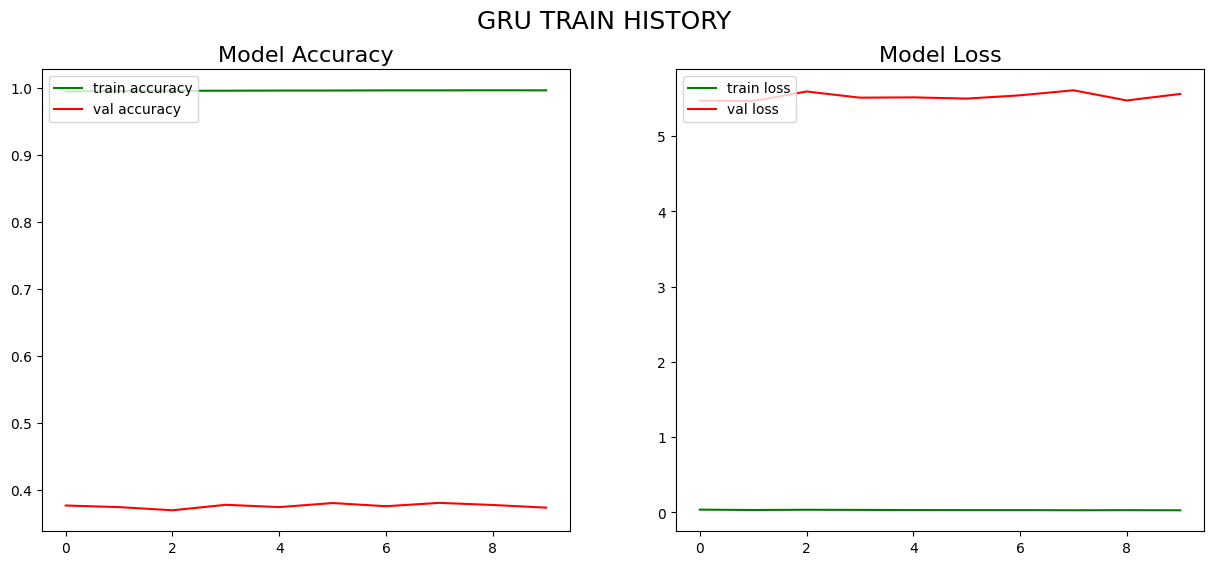

,model,accuracy,precision,recall,f1
0,GRU,37.361769,0.377889,0.373618,0.372252


In [35]:
model_1, res1 = run_model(inputs, outputs, "model_1_GRU", 10, "GRU", "GRU TRAIN HISTORY")
res1

**Bidirectional LSTM**

In bidirectional LSTM, instead of training a single model, we introduce two. The first model learns the sequence of the input provided, and the second model learns the reverse of that sequence.

Bidirectional LSTM (BiLSTM) is a recurrent neural network used primarily on natural language processing. Unlike standard LSTM, the input flows in both directions, and it's capable of utilizing information from both sides.

In [25]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_2_Bidirectional_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirection  (None, 128)               98816     
 al)                                                             
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1379461 (5.26 MB)
Trainabl

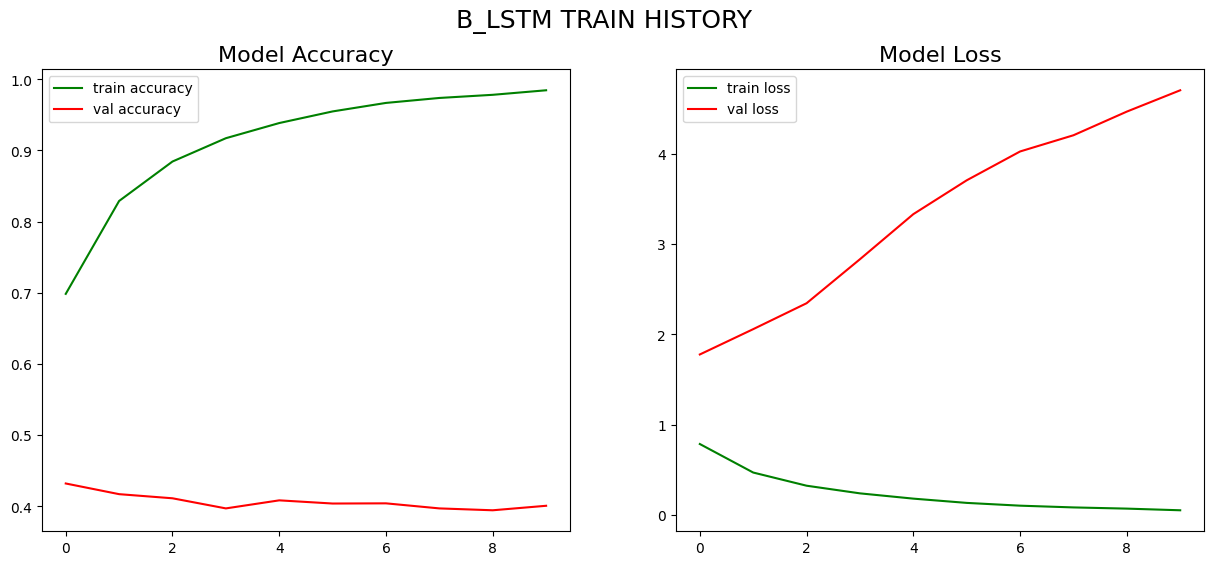

,model,accuracy,precision,recall,f1
0,B_LSTM,40.073723,0.401365,0.400737,0.400021


In [26]:
model_2, res2 = run_model(inputs, outputs, "model_2_Bidirectional_LSTM", 10, "B_LSTM", "B_LSTM TRAIN HISTORY")
res2

**Bidirectional GRU**

Bidirectional wrapper for GRU.

What is the difference between GRU and bidirectional GRU?

A BiGRU (Bidirectional Gated Recurrent Unit) is a type of recurrent neural network (RNN) architecture that extends the traditional GRU (Gated Recurrent Unit) by processing input sequences in both forward and backward directions simultaneously

In [27]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.GRU(64))(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_3_Bidirectional_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               74496     
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 1355141 (5.17 MB)
Trainable

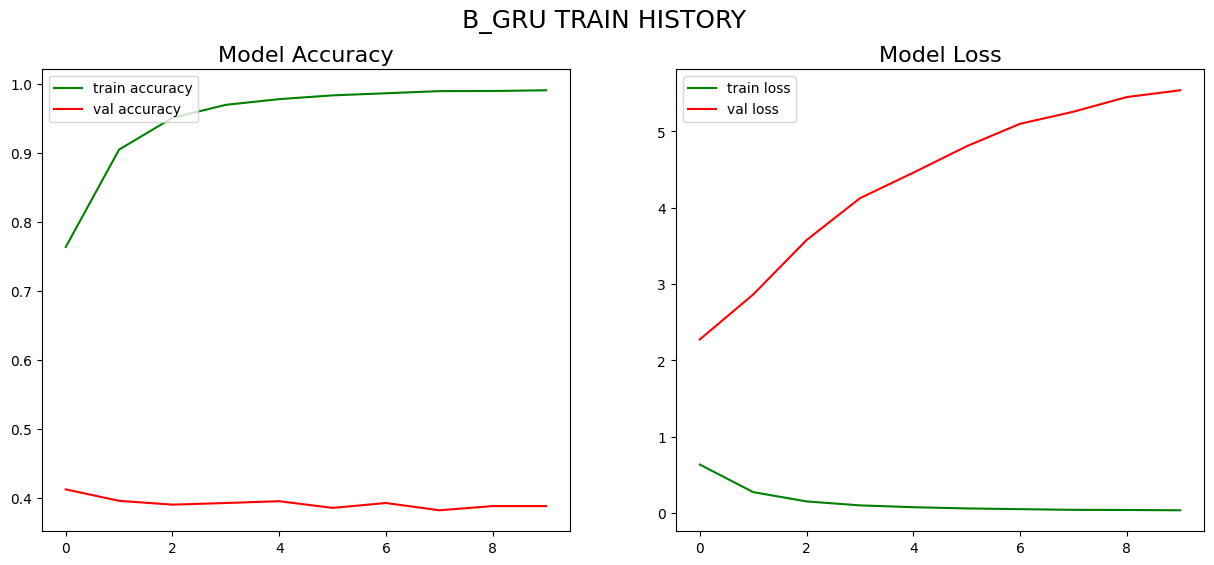

,model,accuracy,precision,recall,f1
0,B_GRU,38.8099,0.387916,0.388099,0.387891


In [28]:
model_3, res3 = run_model(inputs, outputs, "model_3_Bidirectional_GRU", 10, "B_GRU", "B_GRU TRAIN HISTORY")
res3

**Convolutional NN**

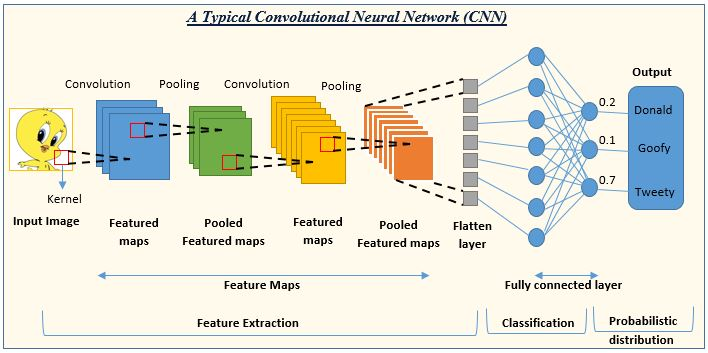

In [30]:
# setting inputs and outputs of NN
inputs = layers.Input(shape=(1,),dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(filters=32, kernel_size=5, activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(units = n_classes, activation = 'softmax')(x)

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embeding_1 (Embedding)      (None, 15, 128)           1280000   
                                                                 
 conv1d (Conv1D)             (None, 11, 32)            20512     
                                                                 
 global_max_pooling1d (Glob  (None, 32)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense_3 (Dense)             (None, 5)              

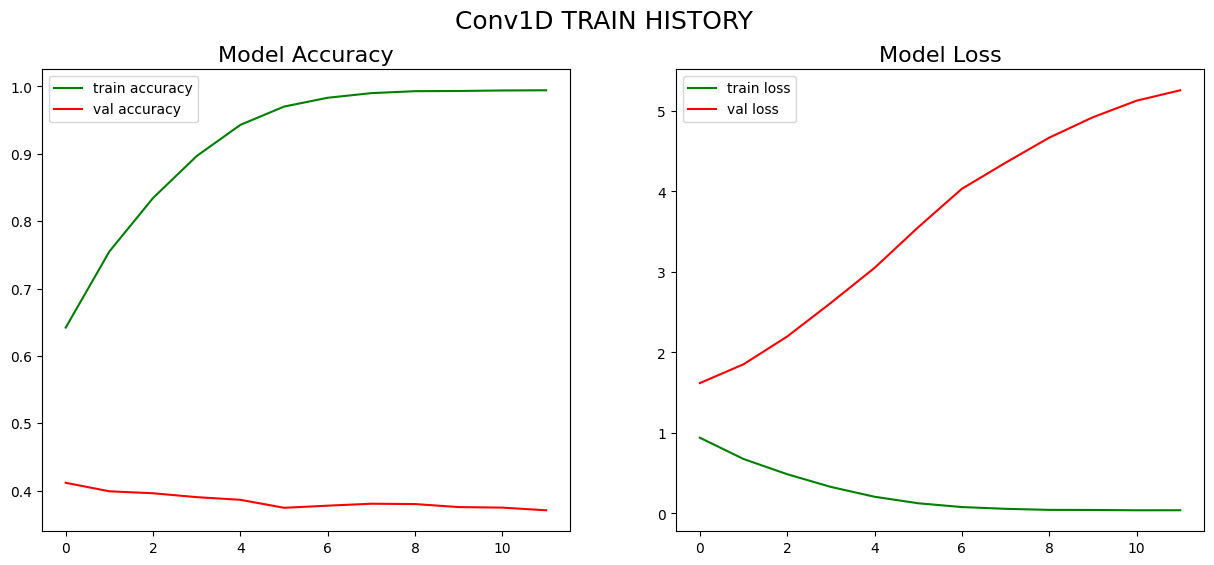

,model,accuracy,precision,recall,f1
0,Conv1D,37.072143,0.371773,0.370721,0.369458


In [31]:
model_4, res4 = run_model(inputs, outputs, "model_4_Conv1D", 12, "Conv1D", "Conv1D TRAIN HISTORY")
res4

**8. Compare models**

In [32]:
results = [res1, res2, res3, res4]
results = pd.concat(results, ignore_index=True)
results.index = results['model']
results = results.drop(columns=['model'])

results # check data

,accuracy,precision,recall,f1
model,,,,
GRU,40.995261,0.411329,0.409953,0.410379
B_LSTM,40.073723,0.401365,0.400737,0.400021
B_GRU,38.809900,0.387916,0.388099,0.387891
Conv1D,37.072143,0.371773,0.370721,0.369458


In [33]:
def plot_results(results, ax1, ax2, ax3, ax4):
    """VISUALIZE RESULTS"""
    # color = ['green', 'cyan', 'blue', 'magenta']
    color1 = plt.cm.spring(np.linspace(0, 1, len(results)))
    color2 = plt.cm.viridis(np.linspace(0, 1, len(results)))
    color3 = plt.cm.winter(np.linspace(0, 1, len(results)))
    color4 = plt.cm.cool(np.linspace(0, 1, len(results)))

    ax1 = results['accuracy'].plot.bar(ax=ax1, color=color1, legend=False)
    ax1.set_title("Accuracy", fontsize=16)

    ax2 = results['precision'].plot.bar(ax=ax2, color=color2, legend=False)
    ax2.set_title("Precision", fontsize=16)

    ax3 = results['recall'].plot.bar(ax=ax3, color=color3, legend=False)
    ax3.set_title("Recall", fontsize=16)

    ax4 = results['f1'].plot.bar(ax=ax4, color=color4, legend=False)
    ax4.set_title("F1", fontsize=16)

    print()

After that, we can plot our data:

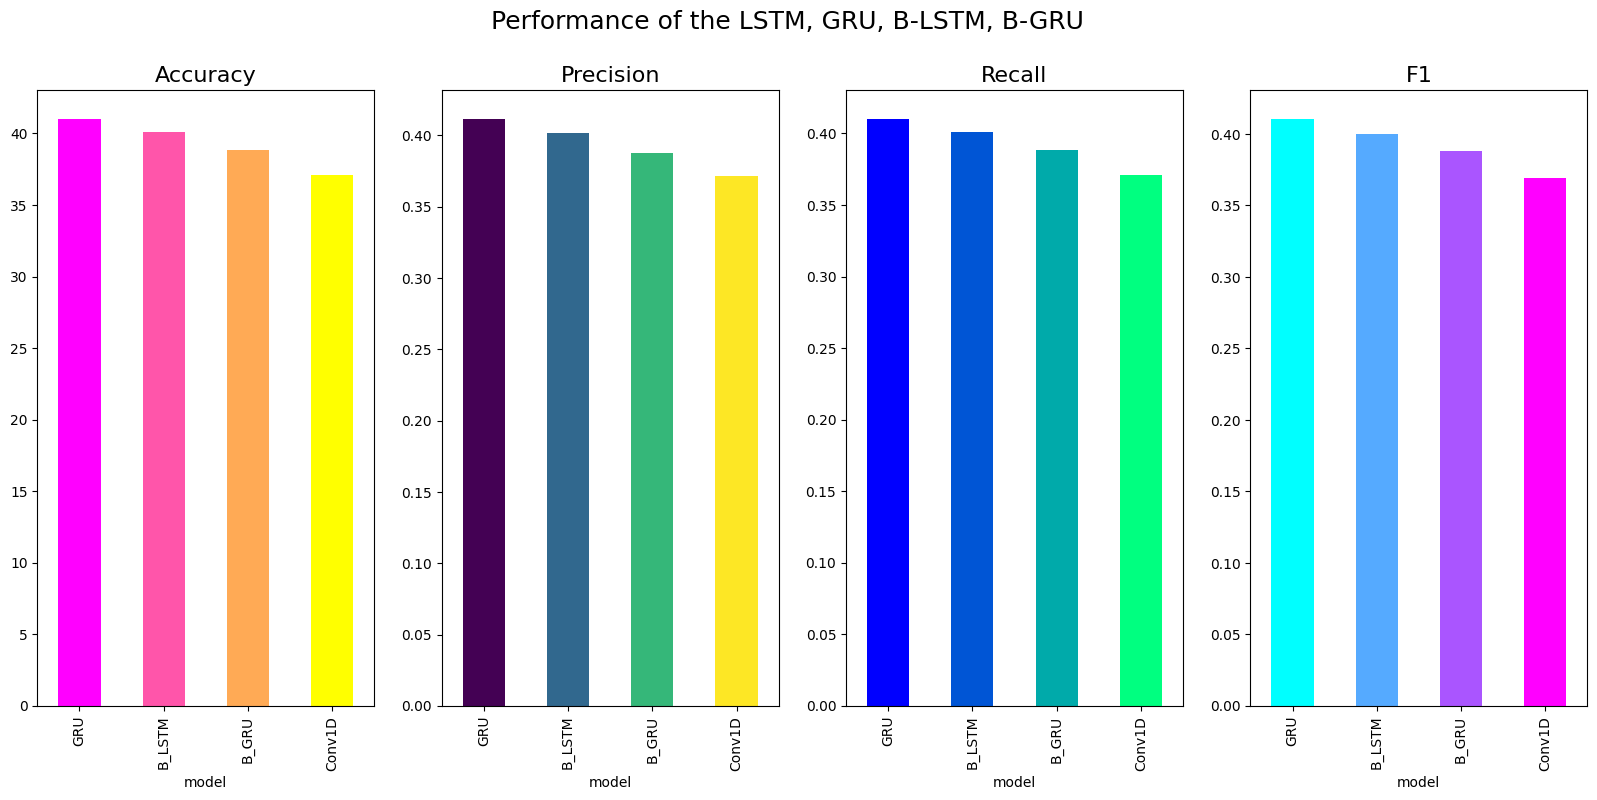

In [34]:
# plot data
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(20,8))
plt.suptitle("Performance of the LSTM, GRU, B-LSTM, B-GRU", fontsize=18)
plot_results(results, ax1, ax2, ax3, ax4)
plt.show()

# **REFERENCES**


[REF 01](https://www.kaggle.com/code/maricinnamon/coronavirus-tweets-classification-nlp-gru/notebook)

[REF 02](https://www.kaggle.com/code/maricinnamon/coronavirus-tweets-classification-nlp-lstm/notebook)


[REF 03](https://www.analyticsvidhya.com/blog/2021/03/introduction-to-gated-recurrent-unit-gru/)